*注：这一章没怎么看得懂，所以笔记没有记录完。*

# 9 Time Series

## 9.1 时间序列简介

时间序列是在商业数据或者工程数据中经常出现的一种数据形式，是以时间为次序排列，用来描述和计量一系列过程或者行为的数据的统称。

一般研究的时间序列数据有两种类型。
* 最常见的是跟踪单一的计量数据随时间变化的情况，即每个时间点上收集的数据是一个一维变量，这种是最常见的，通常的时间序列默认就是这种数据，也是本章研究的对象。
* 另外一种时间序列数据是多个对象或者多个维度的计量数据随时间变化的情况，即每个时间点上收集的数据是一个多维变量，这种一般也被称为纵向数据（Longitudinal Data），但是不属于本章研究的对象。

In [2]:
# 导入需要用到的软件包

%matplotlib inline
import pandas as pd
import numpy as np
# import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize']=(20, 10)

In [ ]:
# 检查StatsModels的版本号
sm.version.full_version

## 9.2　基本概念

有效的时间序列分析依赖于几个核心概念: (有省略)
* 最核心的概念是平稳性(Stationarity): 6
* 第二个概念为白噪声(White Noise): 
* 第三个概念是随机行走（Random Walk）: 

演示一个均值为0.1，标准差为2的100个时间点的白噪声，及其对应的随机行走时间序列。图9.1由以下程序生成。

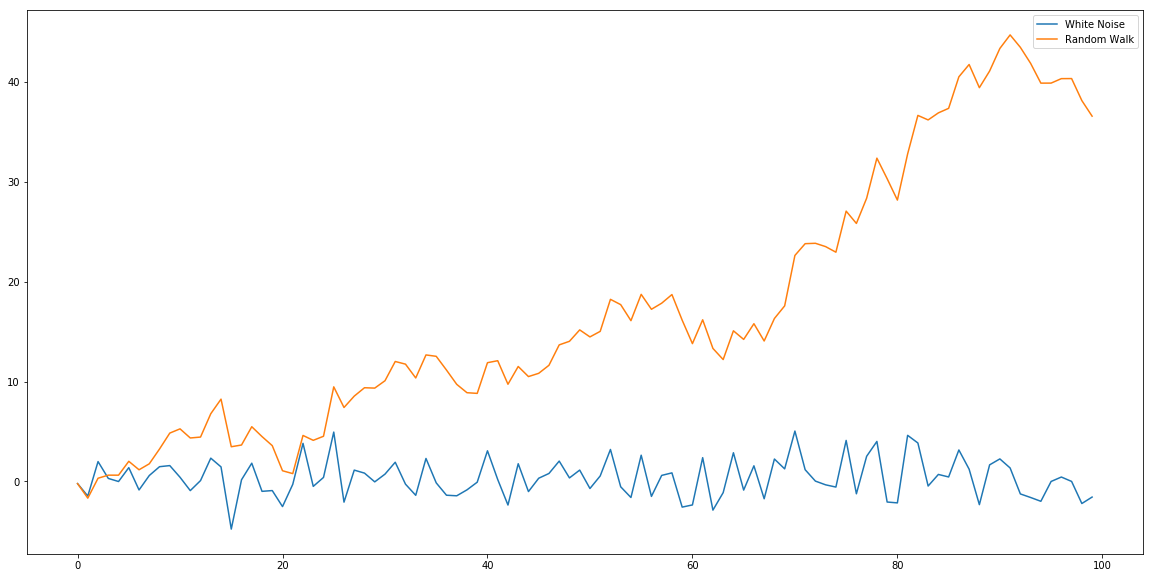

前20个数据点的均值为3.1296， 标准差为2.4466
\
后20个数据点的均值为38.9727， 标准差为3.7553


In [3]:
np.random.seed(1291)
z = np.random.normal(0.1, 2, 100)
y = np.cumsum(z)

fig, axl = plt.subplots()
plt.plot(z, label="White Noise")
plt.plot(y, label="Random Walk")
plt.legend()
plt.show()

mean1 = np.round(np.mean(y[:20]), 4); mean2 = np.round(np.mean(y[-20:]), 4);
std1 = np.round(np.std(y[:20]), 4); std2 = np.round(np.std(y[-20:]), 4)
print("前20个数据点的均值为%.4f， 标准差为%.4f" %(mean1, std1))
print("\\")
print("后20个数据点的均值为%.4f， 标准差为%.4f" %(mean2, std2))

从图9.1中可以看到随机行走时间序列的几个特点。首先这种时间序列数据是非平稳的，其均值和方差都随着时间而变化。

对这个随机行走时间序列取一阶差分作为滤子，过滤后的时间序列则为上例中的白噪声序列。

**可以看到，对于白噪声和随机行走两种不同的时间序列的预测有不同的模型，那么怎么识别一个已知的时间序列是平稳的还是一个随机行走时间序列呢？**

首先，如果要识别一个时间序列是否是平稳的，通过检验单位根的方法，常用的有以下几种，在Python的StatsModels里面都有现成的函数可用。

**Augmented Dickey-Fuller Test（ADF）**

1. ADF是最常见的单位根检验方法。其默认假设待验证的时间序列是不平稳的，如果得到的统计量的p值较大，则说明这个时间序列是不平稳的，如果p较小，则说明这个时间序列是平稳的。假如我们用5%作为p值的界限，那么如果ADF统计量的p值大于0.05则表明时间序列是不平稳的，需要做差分运算，一直到检验结果表明是平稳的为止。
2. 在Python中我们可以用StatsModels软件库里的tsa.stattools.adfuller（x）函数来检验时间序列X的平稳性。

**Kwiatkowski-Phillips-Schmidt-Shin Test（KPSS）**

1. KPSS检验是一种较新的检验方式，与ADF检验相反，其默认假设待验证的时间序列是平稳的，如果得到的统计量p值较大，则说明这个时间序列是平稳的；反之则是不平稳的。
2. 在Python中可以用StatsModels软件库里的tsa.stattools.kpss（x）函数来检验时间序列的平稳性。注意，kpss.test这个函数只在StatsModels0.8以上版本才有。

StatsModels的版本可以通过以下命令查阅：
```python
import statsmodels
print(statsmodels.version.full_version)
```
如果现有系统不是这个版本的statsmodels，可以通过pip升级：
```
pip install statsmodels=0.8.0rcl
```

## 9.3　时间序列模型预测准确度的衡量

**衡量预测准确度的常用统计量:**

（1）平均误差（Mean Error，ME）：

$ME=\frac{1}{T_{2}}\sum_{t=T_{1}+1}^{T_{1}+T_{2}}e_{t}$


平均误差能较好地衡量现有模型是否有很好描述的线性趋势。

（2）平均百分比误差（Mean Percentage Error，MPE）：

$MPE=\frac{1}{T_{2}}\sum_{t=T_{1}+1}^{T_{1}+T_{2}}\frac{e_{t}}{y_{t}}$

平均百分比误差也用于衡量是否有短期趋势没有被模型很好地描述，不过它是以相对误差的形式来表达的。

（3）均方差（Mean Square Error，MSE）：

$MSE=\frac{1}{T_{2}}\sum_{t=T_{1}+1}^{T_{1}+T_{2}}e_{t}^{2}$

均方差相对于平均误差来说，能侦测出线性趋势之外更多的没有被模型描述的数据模式，比如周期性等，因此其更为常用。

（4）平均绝对误差（Mean Absolute Error，MAE）：

$MAE=\frac{1}{T_{2}}\sum_{t=T_{1}+1}^{T_{1}+T_{2}}\left \| e_{t} \right \|$

平均绝对误差在衡量模型的准确度方面和均方差有类似的效果，只是对于异常值相对来说稳健性更高。

（5）平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）：

$ME=\frac{1}{T_{2}}\sum_{t=T_{1}+1}^{T_{1}+T_{2}}\left \| \frac{e_{t}}{y_{t}} \right \|$

MAPE结合了MAE和MPE的优点，能较好地侦测线性趋势之外的更多的数据模式，并以相对误差的形式表达。

**使用样本外数据验证步骤:**

1. 将长度为T=T1+T2的样本时间序列分为两个子序列，其中前面一个（t=1，…，T1）子序列用于模型训练，后面一个子序列（t=T1+1，…，T）用于模型验证。
2. 用第一个子序列训练一个待验证模型。
3. 使用上一步训练的模型，使用时间范围为t=1，…，T1的因变量来预测未来T1+1，…，T时间段的因变量值： 即对用于模型验证部分的子序列因变量使用待验证模型进行拟合。
4. 使用上一步拟合的因变量值和对应的实际因变量值，计算单步预测误差：et=然后采用一种或者多种9.2节介绍的衡量模型准确度的统计量来计算综合预测能力。

可以对每一个待验证模型都执行第（2）到第（4）步，选取综合预测能力最好，即统计量值最小的那个待选模型。

## 9.4　时间序列数据示例

我们的时间序列数据来自于DataMarket的时间序列数据库：https://datamarket.com/data/list/?q=provider:tsdl 这个库由澳大利亚莫纳什大学的统计学教授Rob Hyndman创建，收集了数十个公开的时间序列数据集。本章我们采用其中两个数据作为实例。Rob Hyndman教授也是R统计语言里面forecast软件包的开发者。

第一个数据是在汉口测量的长江每月流量数据，其文件名为monthly-flows-changjiang-at-hankou.csv，读者可以到www.broadview.com.cn/31872 下载。该数据记录了从1865年1月到1978年12月在汉口记录的长江每月的流量，总计1368个数据点，计量单位未知，不过这不妨碍我们的分析过程和结果。我们将该数据下载后在本地磁盘存为：
E:\data\TimeSeries\monthly-flows-chang-jiang-athankou.csv。

从图9.2可以看出，该数据具备很强的不同长度的周期性。

第二个数据是从1949年1月到1960年12月的月度国际航空旅客数量，其文件名为internationalairline-passengers.csv，读者可以到www.broadview.com.cn/31872 下载。该数据有144个数据点，数据单位为千人，与第一个数据不同的是，该数据包含极强的趋势要素和周期要素，因此在具体的分析上能体现不同的要求。该数据下载后在本地磁盘存为：E：\data\TimeSeries\international-airlinepassengers.csv。

下面读入该数据并展示，如图9.3所示。

## 9.7　应用案例

本节应用前面学到的理论对真实的时间序列数据进行建模并预测。这里会用到前面提到的长江汉口地区月度流量数据和全球航空公司月度乘客数量两个时间序列数据，具体介绍如何应用ARIMA模型和LSTM模型对时间序列数据进行建模和预测，并对两种模型的实际预测能力进行比较。在使用ARIMA模型进行建模的时候，按照下面的标准步骤操作。

1. 首先对示例数据进行标准分析，包括识别其平稳性以及是否是随机行走或者具备单位根问题。
2. 使用周期图法（Periodogram）来识别季节性。
3. 对于去除季节性的数据，通过ACF和PACF函数提供的信息得到自回归和移动平均部分所需的滞后项个数。这些数据用于对ARIMA（p，d，q）模型的参数进行标定。
4. 然后对时间序列数据进行拟合，并得到相应的检验量。
5. 对残差检验Q统计量和JB统计量以及计算ACF和PACF函数，确定没有额外的信息游离于模型之外。
6. 最后对样本外的测试数据进行预测并检验模型的准确度。

在使用LSTM模型对时间序列建模的时候，我们依然需要进行前面的第（1）和第（2）步和第（4）步，但是中间的步骤略有不同。
1. 首先对示例数据进行标准分析，包括识别其平稳性以及是否是随机行走或者具备单位根问题。
2. 使用周期图法（Periodogram）来识别季节性。
3. 对于去除季节性的数据，通过ACF和PACF函数提供的信息得到建模所需包含的滞后项个数，包括在LSTM模型中需要将多久以前的信息带入当期。
4. 对数据进行处理，使其符合Keras软件包的LSTM模型API的要求。
5. 拟合多种不同结构的LSTM模型并比较其在样本内数据上的表现。
6. 对残差计算ACF和PACF函数，确定没有额外的信息游离于模型之外。
7. 最后对样本外的数据进行预测，并检验其表现。

我们先载入数据分析和建模所需的软件库。

In [ ]:
import Keras.models as kModels
import Keras.layers as kLayers
from scipy.singal import periodogram
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


在我们的案例中，信息显示我们使用GPU作为计算核心，同时启动了cuDNN库。这里不再展示了。

### 9.7.1　长江汉口月度流量时间序列模型

在第一例子里，我们对长江流量的月度数据进行建模，先建立一个ARIMA模型，再建立一个基于LSTM的深度学习模型，最后我们比较两个模型的预测性能。在建模之前，我们先将数据分为训练集合和样本外测试集。我们将最后24个月的数据留作测试集，其余的作为训练集。

In [ ]:
cutoff = 24
train = df1.WaterFlow[:-cutoff]
test = df1.WaterFlow[-cutoff:]

作为数据分析的第一步，首先我们检验这组数据是否平稳，以及分析其是否需要进行相应的操作以获得平稳性。根据前面提到的平稳性检验方法，我们可以通过观测移动平均和移动均方差随时间的变化图，以及正式的Dicky-Fuller和KPSS检验来实现。下面我们构造一个函数，将这些功能都集成在里面。

下面我们对整个训练集和训练集的局部执行上述函数检验平稳性，如图9.7 平稳性检验 所示。

## 9.8　总结

本章介绍了时间序列模型的基本概念，并介绍和比较了传统的ARIMA模型与新兴的LSTM深度学习模型。我们发现，当使用有一定周期性的时间序列数据进行建模和预测时，简单的LSTM模型已经能很容易地达到需要仔细分析周期性和各项建模参数的（S）ARIMA模型的预测效果。我们在这种情况下不需要花费大量的精力对数据进行处理来达到平稳性以便适用传统的ARIMA模型建模。相反，深度学习模型能够自动发现非平稳数据里的趋势性和异方差性，并对这两种数据的模式建模，在迭代一定的次数之后达到较好的预测效果。我们甚至能够叠加多个LSTM层，在迭代较少的次数时就能识别数据的特征进行预测。

当然，深度学习模型的算法属于随机算法，我们有时候需要进行多次拟合，试着设定不同的初始值才能得到合适的结果。深度学习模型也比较容易过度拟合，在不同层之间加入连接断开层（Dropout）或者在LSTM层设置递归权重或者偏置权重进行正则化处理，可以在一定程度上防止发生过度拟合。

另外，虽然使用一些非线性变换，比如取自然对数，能有效处理数据的异方差性，并帮助传统的ARIMA模型提高预测能力，但是这个方法对深度学习模型并不适用。当应用了变换后的数据来训练深度学习模型，其预测能力反而不如使用原始数据的时候效果好。